In [36]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS


In [37]:
def fetch_stock_data(symbol, start_date, end_date, api_key):
    # Define the API endpoint and parameters
    endpoint = "https://api.twelvedata.com/time_series"
    params = {
        "symbol": symbol,
        "start_date": start_date,
        "end_date": end_date,
        "interval": "1day",
        "apikey": api_key
    }

    try:
        # Send the HTTP request
        response = requests.get(endpoint, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()

        # Check if API returned an error message
        if 'error' in data:
            print("Error:", data['error'])
            return None

        return data['values']

    except requests.exceptions.RequestException as e:
        print("Error fetching data:", e)
        return None

def main():
    symbols = ["COIN", "BTC/USD", "ETH/USD"]  # Symbols for Coinbase, Bitcoin, and Ethereum
    start_date = "2013-01-01"  # Specify your start date
    end_date = "2024-04-01"    # Specify your end date
    api_key = os.getenv("TWELVE_DATA_API_KEY")

    # Create an empty DataFrame to store the data
    df = pd.DataFrame(columns=["Date"])

    for symbol in symbols:
        # Fetch stock data
        stock_data = fetch_stock_data(symbol, start_date, end_date, api_key)
        if stock_data:
            # Populate the DataFrame with fetched data
            symbol_data = []
            for data_point in stock_data:
                timestamp = datetime.fromisoformat(data_point['datetime'])
                close_price = data_point['close']
                symbol_data.append({"Date": timestamp, symbol: close_price})
            
            # Create DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(symbol_data)
            
            # Merge with the main DataFrame on the common "Date" column
            df = pd.merge(df, symbol_df, on="Date", how="outer")

            # Print the symbol and length of DataFrame
            print(f"Symbol: {symbol}, Length of DataFrame: {len(df)}")

    # Sort DataFrame by date
    df.sort_values(by="Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Remove rows with N/A values and set the Date as the index

    df.dropna(inplace=True)
    df.set_index("Date", inplace=True)

    # Return the DataFrame
    return df

In [38]:
# Call the main function and store the returned DataFrame
clean_data = main()

print("Number of rows in DataFrame:", len(clean_data))
print(clean_data.head())

Symbol: COIN, Length of DataFrame: 745
Symbol: BTC/USD, Length of DataFrame: 3303
Symbol: ETH/USD, Length of DataFrame: 3303
Number of rows in DataFrame: 640
                 COIN      BTC/USD     ETH/USD
Date                                          
2021-09-13  242.84000  44947.69141  3284.03003
2021-09-14  243.00000  47130.89844  3429.45996
2021-09-15  247.07001  48148.12109  3613.13989
2021-09-16  243.21001  47753.16016  3568.30005
2021-09-17  245.19000  47301.23047  3399.03003


In [39]:
final_data = clean_data.copy()
final_data = final_data.apply(pd.to_numeric)

# Display correlation matrix

correlation_matrix = final_data[['COIN', 'BTC/USD', 'ETH/USD']].corr()
print(correlation_matrix)

             COIN   BTC/USD   ETH/USD
COIN     1.000000  0.912992  0.960103
BTC/USD  0.912992  1.000000  0.929395
ETH/USD  0.960103  0.929395  1.000000


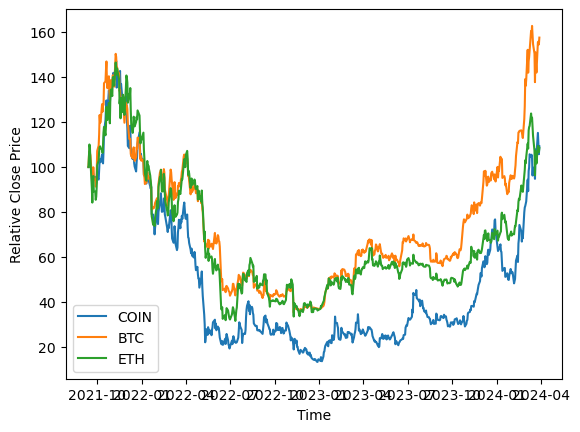

In [40]:
final_data['COIN_Relative_Close'] = final_data['COIN']/final_data['COIN'][0] * 100
final_data['BTC_Relative_Close'] = final_data['BTC/USD']/final_data['BTC/USD'][0] * 100
final_data['ETH_Relative_Close'] = final_data['ETH/USD']/final_data['ETH/USD'][0] * 100

plt.plot(final_data['COIN_Relative_Close'], label= 'COIN')
plt.plot(final_data['BTC_Relative_Close'], label= 'BTC')
plt.plot(final_data['ETH_Relative_Close'], label= 'ETH')
plt.xlabel('Time')
plt.ylabel('Relative Close Price')
plt.legend()
plt.show()

In [41]:
final_data['COIN_Change'] = (final_data['COIN'] - final_data['COIN'].shift(1)) / final_data['COIN'].shift(1)
final_data['BTC_Change'] = (final_data['BTC/USD'] - final_data['BTC/USD'].shift(1)) / final_data['BTC/USD'].shift(1)
final_data['ETH_Change'] = (final_data['ETH/USD'] - final_data['ETH/USD'].shift(1)) / final_data['ETH/USD'].shift(1)


print(final_data.head())

                 COIN      BTC/USD     ETH/USD  COIN_Relative_Close  \
Date                                                                  
2021-09-13  242.84000  44947.69141  3284.03003           100.000000   
2021-09-14  243.00000  47130.89844  3429.45996           100.065887   
2021-09-15  247.07001  48148.12109  3613.13989           101.741892   
2021-09-16  243.21001  47753.16016  3568.30005           100.152368   
2021-09-17  245.19000  47301.23047  3399.03003           100.967715   

            BTC_Relative_Close  ETH_Relative_Close  COIN_Change  BTC_Change  \
Date                                                                          
2021-09-13          100.000000          100.000000          NaN         NaN   
2021-09-14          104.857217          104.428398     0.000659    0.048572   
2021-09-15          107.120343          110.021524     0.016749    0.021583   
2021-09-16          106.241630          108.656133    -0.015623   -0.008203   
2021-09-17          105.2361

In [42]:
# Compute the Engle-Granger cointegration test
def test_cointegration(data1, data2):
    result = coint(data1, data2)
    return result[1]

# Perform the Dickey-Fuller test for stationarity
def test_stationarity(data):
    adf_result = adfuller(data)
    return adf_result[1]

# Get all combinations of pairs
def get_pairs_to_test(column_names):
    return list(combinations(column_names, 2))

# Test cointegration and stationarity for selected pairs
def test_pairs(price_data, pairs_to_test):
    for pair in pairs_to_test:
        stock_A = price_data[pair[0]]
        stock_B = price_data[pair[1]]
        print("Testing pair:", pair)
        cointegration_p_value = test_cointegration(stock_A, stock_B)
        print("Cointegration test p-value:", cointegration_p_value)
        if cointegration_p_value < 0.05:
            print("The two time series are likely cointegrated.")
        else:
            print("The two time series are likely not cointegrated.")
        stationarity_p_value_A = test_stationarity(stock_A)
        stationarity_p_value_B = test_stationarity(stock_B)
        print("Dickey-Fuller test p-value for", pair[0] + ":", stationarity_p_value_A)
        print("Dickey-Fuller test p-value for", pair[1] + ":", stationarity_p_value_B)
        print("\n")

# Specify which columns to use for testing pairs
columns_to_test = ['COIN_Relative_Close', 'BTC_Relative_Close', 'ETH_Relative_Close']

# Get pairs to test
pairs_to_test = get_pairs_to_test(columns_to_test)

# Test cointegration and stationarity for selected pairs
test_pairs(final_data, pairs_to_test)

Testing pair: ('COIN_Relative_Close', 'BTC_Relative_Close')
Cointegration test p-value: 0.5078748395969164
The two time series are likely not cointegrated.
Dickey-Fuller test p-value for COIN_Relative_Close: 0.6296095506033662
Dickey-Fuller test p-value for BTC_Relative_Close: 0.9366223342917435


Testing pair: ('COIN_Relative_Close', 'ETH_Relative_Close')
Cointegration test p-value: 0.003950273412124983
The two time series are likely cointegrated.
Dickey-Fuller test p-value for COIN_Relative_Close: 0.6296095506033662
Dickey-Fuller test p-value for ETH_Relative_Close: 0.6404338389769271


Testing pair: ('BTC_Relative_Close', 'ETH_Relative_Close')
Cointegration test p-value: 0.9806024252269365
The two time series are likely not cointegrated.
Dickey-Fuller test p-value for BTC_Relative_Close: 0.9366223342917435
Dickey-Fuller test p-value for ETH_Relative_Close: 0.6404338389769271




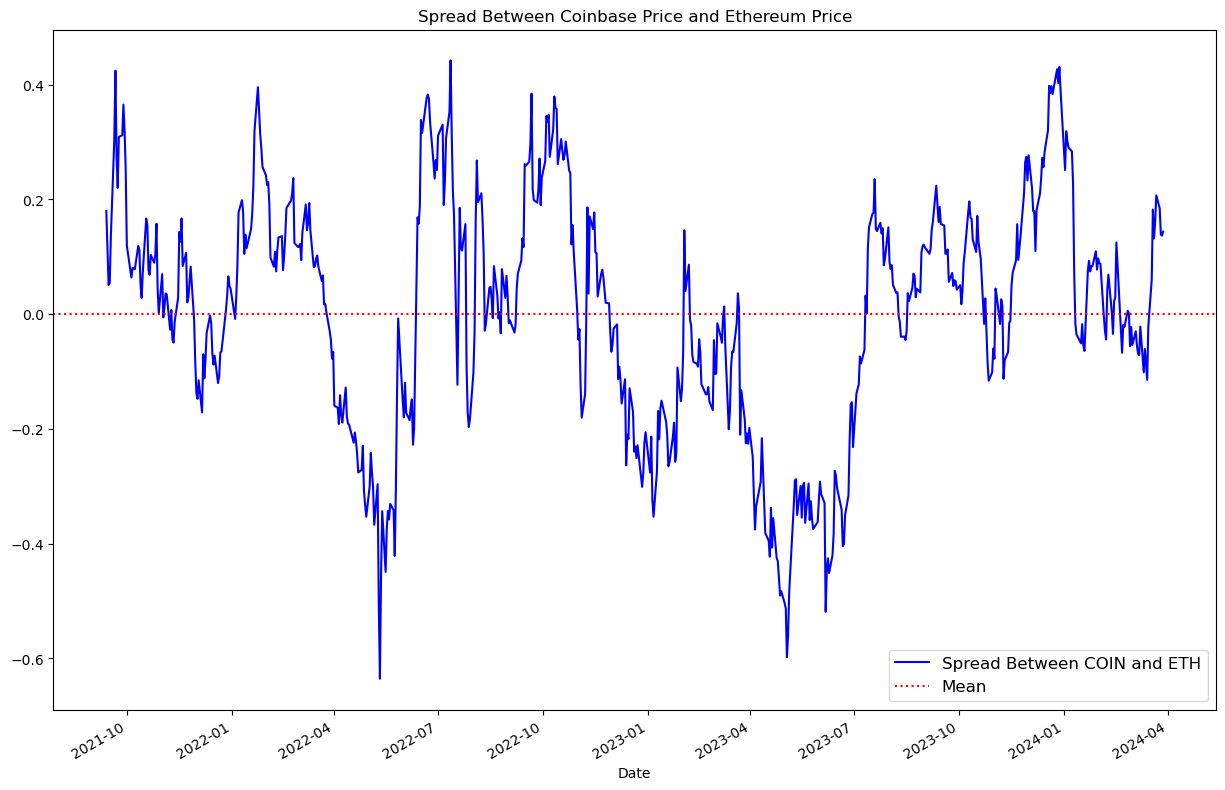

In [45]:
# Creating a regression model

Asset_1 = final_data['COIN_Relative_Close']
Asset_2 = final_data['ETH_Relative_Close']

Y = np.log(Asset_1)
X = np.log(Asset_2)
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
results.params


# Get spread
alpha = results.params.values[0]
beta = results.params.values[1]
errors = Y - (alpha + X['ETH_Relative_Close']*beta)

#Chart the spread

errors.plot(figsize=(15,10), color = 'blue')
plt.axhline(errors.mean(), color='red', linestyle=':')
plt.legend(['Spread Between COIN and ETH', 'Mean'], prop={'size': 12});
plt.title("Spread Between Coinbase Price and Ethereum Price")
plt.show()